In [1]:
import numpy as np 
import pandas as pd 
import os

import gc
import sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from tqdm.notebook import tqdm
from matplotlib.colors import Normalize
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import keras.backend as K
from keras.models import Sequential
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import load_model
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv("/content/drive/Othercomputers/My MacBook Pro/happy-whale/input/train.csv")
train_df.head()
train_df_small = train_df[:50]
print(train_df_small.image)

0     00021adfb725ed.jpg
1     000562241d384d.jpg
2     0007c33415ce37.jpg
3     0007d9bca26a99.jpg
4     00087baf5cef7a.jpg
5     000a8f2d5c316a.jpg
6     000be9acf46619.jpg
7     000bef247c7a42.jpg
8     000c3d63069748.jpg
9     000c476c11bad5.jpg
10    001001f099519f.jpg
11    00103cbe9d25ce.jpg
12    00144776eb476d.jpg
13    00167e8375c967.jpg
14    00177f3c614d1e.jpg
15    0017b3749cd769.jpg
16    0018064338b499.jpg
17    001b0900f56e89.jpg
18    001cfade605960.jpg
19    001f1a1f22da96.jpg
20    0020004d64ae20.jpg
21    00206a224e68de.jpg
22    0022bdb8eb5684.jpg
23    00234b893ea9e8.jpg
24    0024057bbc89a4.jpg
25    00243d4b15bafc.jpg
26    002618d6f63ebc.jpg
27    0028f6fa123686.jpg
28    0029d877c29ab4.jpg
29    002ac5f9ad7c10.jpg
30    002e00960cec44.jpg
31    002fb5fee50b97.jpg
32    0030835e895969.jpg
33    0032f90c7732b0.jpg
34    00354cd9244e28.jpg
35    0036b5c11b39f3.jpg
36    0038d3be2513c0.jpg
37    0039599b58fc80.jpg
38    00398cfc6f6675.jpg
39    0039955230421d.jpg


In [4]:
print("Total species before finding duplicates :",len(train_df.species.unique()))
train_df.species = train_df.species.str.replace('kiler_whale','killer_whale')
train_df.species = train_df.species.str.replace('bottlenose_dolpin','bottlenose_dolphin')
train_df['species'][(train_df['species'] =="pilot_whale") | (train_df['species'] =="globis" )]='short_finned_pilot_whale'
print("Total species after :",len(train_df.species.unique()))

Total species before finding duplicates : 30
Total species after : 26


In [5]:
animal_cnt = train_df.species.value_counts()
print("Occurences of different species:")
print(animal_cnt)
print(f"Total number of species: {len(animal_cnt)}")

Occurences of different species:
bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
southern_right_whale           866
short_finned_pilot_whale       745
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
long_finned_pilot_whale        238
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64
Total number of species: 26


In [ ]:
specs = list(animal_cnt.keys())
values = list(animal_cnt.values)

cmap = cm.get_cmap('jet')
norm = Normalize(vmin=0,vmax=len(specs))
cols = np.arange(0,len(specs))
#
#fig = plt.figure(figsize=(10,6))
#ax = fig.add_subplot(1,1,1)
#ax.set_axisbelow(True)
#plt.grid(visible=True)
#plt.bar(specs, values, color=cmap(norm(cols)))
#plt.xticks(rotation='vertical')
#plt.title('Occurences Of Different Species In The Dataset', fontsize=16, fontname="Times New Roman Bold")
#plt.show()
#

In [ ]:
print(train_df.shape)
print(train_df_small.shape)

(51033, 4)
(50, 4)


In [ ]:
train_jpg_path = "/content/drive/Othercomputers/My MacBook Pro/happy-whale/input/cropped_test_images/cropped_test_images/"
test_jpg_path = "/content/drive/Othercomputers/My MacBook Pro/happy-whale/input/cropped_train_images/cropped_train_images/"
#train_images_list = os.listdir('/content/drive/Othercomputers/My MacBook Pro/happy-whale/input/cropped_train_images/cropped_train_images')
#train_images_list

In [ ]:
def Loading_Images(data, m, dataset):
    print("Loading images")
    X_train = np.zeros((m, 32, 32, 3))
    count = 0
    for fig in tqdm(data['image']):
        img = image.load_img("/content/drive/Othercomputers/My MacBook Pro/happy-whale/input"+dataset+"/"+fig, target_size=(32, 32, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
    return X_train

In [ ]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder

In [ ]:
X = Loading_Images(train_df, train_df.shape[0], "/cropped_train_images/cropped_train_images")
X /= 255

Loading images


  0%|          | 0/51033 [00:00<?, ?it/s]

In [ ]:
y, label_encoder = prepare_labels(train_df['species'])

In [ ]:
%env

{'NVIDIA_VISIBLE_DEVICES': 'all',
 'HOSTNAME': 'ds01',
 'NVIDIA_REQUIRE_CUDA': 'cuda>=11.2 brand=tesla,driver>=418,driver<419 brand=tesla,driver>=440,driver<441 driver>=450',
 'NV_ML_REPO_ENABLED': '1',
 'PWD': '/workspace',
 'NVIDIA_DRIVER_CAPABILITIES': 'compute,utility',
 'NV_CUDA_CUDART_VERSION': '11.2.146-1',
 'HOME': '/',
 'LANG': 'C.UTF-8',
 'CUDA_VERSION': '11.2.1',
 'TERM': 'xterm-color',
 'NV_ML_REPO_URL': 'https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64',
 'DISPLAY': '',
 'SHLVL': '0',
 'NVARCH': 'x86_64',
 'NV_CUDA_COMPAT_PACKAGE': 'cuda-compat-11-2',
 'LD_LIBRARY_PATH': '/usr/local/cuda-11.0/targets/x86_64-linux/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64',
 'PS1': '\\[\\e\\]tf-docker\\[\\e[m\\] \\[\\e\\]\\w\\[\\e[m\\] > ',
 'PATH': '/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
 'DEBIAN_FRONTEND': 'noninteractive'

In [ ]:
print(X.shape)
print(y.shape)
gc.collect()

(51033, 32, 32, 3)
(51033, 26)


520

In [ ]:
y.shape

(51033, 26)

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

B7_model = EfficientNetB7(input_shape=(32,32,3), weights=None, include_top=False)

layer = B7_model.output
#layer = GlobalAveragePooling2D()(layer)#extra
#layer = Dropout(0.5)(layer)#extra
layer = Dense(1024, activation='relu')(layer)
#layer = Dense(512, activation='relu')(layer)#extra
layer = Flatten()(layer)
predictions = Dense(y.shape[1], activation='softmax')(layer)
model = Model(inputs=B7_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                                                                                              

 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1c_se_reduce[0][0]']      
                                                                                                  
 block1c_se_excite (Multiply)   (None, 16, 16, 32)   0           ['block1c_activation[0][0]',     
          

                                                                  'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, 8, 8, 48)     9216        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 8, 8, 48)    192         ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 8, 8, 288)    13824       ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 8, 8, 288)   1152        ['block2b_expand_conv[0][0]']    
 ization) 

                                                                  'block2b_add[0][0]']            
                                                                                                  
 block2d_expand_conv (Conv2D)   (None, 8, 8, 288)    13824       ['block2c_add[0][0]']            
                                                                                                  
 block2d_expand_bn (BatchNormal  (None, 8, 8, 288)   1152        ['block2d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2d_expand_activation (Act  (None, 8, 8, 288)   0           ['block2d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2d_d

 ization)                                                                                         
                                                                                                  
 block2f_expand_activation (Act  (None, 8, 8, 288)   0           ['block2f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2f_dwconv (DepthwiseConv2  (None, 8, 8, 288)   2592        ['block2f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2f_bn (BatchNormalization  (None, 8, 8, 288)   1152        ['block2f_dwconv[0][0]']         
 )                                                                                                
          

 block3a_dwconv_pad (ZeroPaddin  (None, 11, 11, 288)  0          ['block3a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 4, 4, 288)   7200        ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 4, 4, 288)   1152        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 4, 4, 288)   0           ['block3a_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3c_se_squeeze (GlobalAver  (None, 480)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3c_se_reduce[0][0]']      
          

 block3e_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3e_se_squeeze[0][0]']     
                                                                                                  
 block3e_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block3e_se_reshape[0][0]']     
                                                                                                  
 block3e_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block3e_se_reduce[0][0]']      
                                                                                                  
 block3e_se_excite (Multiply)   (None, 4, 4, 480)    0           ['block3e_activation[0][0]',     
                                                                  'block3e_se_expand[0][0]']      
                                                                                                  
 block3e_project_conv (Conv2D)  (None, 4, 4, 80)     38400       ['block3e_se_excite[0][0]']      
          

                                                                                                  
 block3g_se_excite (Multiply)   (None, 4, 4, 480)    0           ['block3g_activation[0][0]',     
                                                                  'block3g_se_expand[0][0]']      
                                                                                                  
 block3g_project_conv (Conv2D)  (None, 4, 4, 80)     38400       ['block3g_se_excite[0][0]']      
                                                                                                  
 block3g_project_bn (BatchNorma  (None, 4, 4, 80)    320         ['block3g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3g_drop (Dropout)         (None, 4, 4, 80)     0           ['block3g_project_bn[0][0]']     
          

 lization)                                                                                        
                                                                                                  
 block4b_drop (Dropout)         (None, 2, 2, 160)    0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 2, 2, 160)    0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 2, 2, 960)    153600      ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 2, 2, 960)   3840        ['block4c_expand_conv[0][0]']    
 ization) 

                                                                  'block4c_add[0][0]']            
                                                                                                  
 block4e_expand_conv (Conv2D)   (None, 2, 2, 960)    153600      ['block4d_add[0][0]']            
                                                                                                  
 block4e_expand_bn (BatchNormal  (None, 2, 2, 960)   3840        ['block4e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4e_expand_activation (Act  (None, 2, 2, 960)   0           ['block4e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4e_d

 ization)                                                                                         
                                                                                                  
 block4g_expand_activation (Act  (None, 2, 2, 960)   0           ['block4g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4g_dwconv (DepthwiseConv2  (None, 2, 2, 960)   8640        ['block4g_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4g_bn (BatchNormalization  (None, 2, 2, 960)   3840        ['block4g_dwconv[0][0]']         
 )                                                                                                
          

 block4i_dwconv (DepthwiseConv2  (None, 2, 2, 960)   8640        ['block4i_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4i_bn (BatchNormalization  (None, 2, 2, 960)   3840        ['block4i_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4i_activation (Activation  (None, 2, 2, 960)   0           ['block4i_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4i_se_squeeze (GlobalAver  (None, 960)         0           ['block4i_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 2, 2, 960)   0           ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 960)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 2, 2, 1344)   0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 2, 2, 224)    301056      ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 2, 2, 224)   896         ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block5e_project_conv (Conv2D)  (None, 2, 2, 224)    301056      ['block5e_se_excite[0][0]']      
                                                                                                  
 block5e_project_bn (BatchNorma  (None, 2, 2, 224)   896         ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_drop (Dropout)         (None, 2, 2, 224)    0           ['block5e_project_bn[0][0]']     
                                                                                                  
 block5e_add (Add)              (None, 2, 2, 224)    0           ['block5e_drop[0][0]',           
                                                                  'block5d_add[0][0]']            
          

                                                                                                  
 block5g_drop (Dropout)         (None, 2, 2, 224)    0           ['block5g_project_bn[0][0]']     
                                                                                                  
 block5g_add (Add)              (None, 2, 2, 224)    0           ['block5g_drop[0][0]',           
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 2, 2, 1344)   301056      ['block5g_add[0][0]']            
                                                                                                  
 block5h_expand_bn (BatchNormal  (None, 2, 2, 1344)  5376        ['block5h_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5j_expand_conv (Conv2D)   (None, 2, 2, 1344)   301056      ['block5i_add[0][0]']            
                                                                                                  
 block5j_expand_bn (BatchNormal  (None, 2, 2, 1344)  5376        ['block5j_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5j_expand_activation (Act  (None, 2, 2, 1344)  0           ['block5j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5j_dwconv (DepthwiseConv2  (None, 2, 2, 1344)  33600       ['block5j_expand_activation[0][0]
 D)       

 ivation)                                                                                         
                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 1, 1, 2304)  57600       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 1, 1, 2304)  9216        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 1, 1, 2304)  0           ['block6b_bn[0][0]']             
 )                                                                                                
          

 block6d_bn (BatchNormalization  (None, 1, 1, 2304)  9216        ['block6d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 1, 1, 2304)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 2304)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6d_se_squeeze[0][0]']     
          

                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 2304)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_s

                                                                                                  
 block6h_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6h_se_reshape[0][0]']     
                                                                                                  
 block6h_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6h_se_reduce[0][0]']      
                                                                                                  
 block6h_se_excite (Multiply)   (None, 1, 1, 2304)   0           ['block6h_activation[0][0]',     
                                                                  'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 1, 1, 384)    884736      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_p

 block6j_se_excite (Multiply)   (None, 1, 1, 2304)   0           ['block6j_activation[0][0]',     
                                                                  'block6j_se_expand[0][0]']      
                                                                                                  
 block6j_project_conv (Conv2D)  (None, 1, 1, 384)    884736      ['block6j_se_excite[0][0]']      
                                                                                                  
 block6j_project_bn (BatchNorma  (None, 1, 1, 384)   1536        ['block6j_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6j_drop (Dropout)         (None, 1, 1, 384)    0           ['block6j_project_bn[0][0]']     
                                                                                                  
 block6j_a

 block6l_project_bn (BatchNorma  (None, 1, 1, 384)   1536        ['block6l_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6l_drop (Dropout)         (None, 1, 1, 384)    0           ['block6l_project_bn[0][0]']     
                                                                                                  
 block6l_add (Add)              (None, 1, 1, 384)    0           ['block6l_drop[0][0]',           
                                                                  'block6k_add[0][0]']            
                                                                                                  
 block6m_expand_conv (Conv2D)   (None, 1, 1, 2304)   884736      ['block6l_add[0][0]']            
                                                                                                  
 block6m_e

 block7b_expand_bn (BatchNormal  (None, 1, 1, 3840)  15360       ['block7b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7b_expand_activation (Act  (None, 1, 1, 3840)  0           ['block7b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7b_dwconv (DepthwiseConv2  (None, 1, 1, 3840)  34560       ['block7b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7b_bn (BatchNormalization  (None, 1, 1, 3840)  15360       ['block7b_dwconv[0][0]']         
 )        

                                                                                                  
 block7d_dwconv (DepthwiseConv2  (None, 1, 1, 3840)  34560       ['block7d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7d_bn (BatchNormalization  (None, 1, 1, 3840)  15360       ['block7d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7d_activation (Activation  (None, 1, 1, 3840)  0           ['block7d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7d_s

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.20,
                                   )

#train_datagen.fit(X)
gc.collect()

0

In [ ]:
#history = model.fit(train_datagen.flow(X,y,batch_size=128,subset='training'),validation_data=train_datagen.flow(X,y,batch_size=128,subset='validation'),epochs=180)
history = model.fit(X, y, epochs=200, batch_size=128, verbose=1)

Epoch 1/200


In [ ]:
model.save('./effb7_0_species.h5')

In [ ]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (6, 6), strides = (1, 1), input_shape = (32, 32, 3)))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
      
    model.add(Conv2D(64, (3, 3), strides = (1,1)))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3)))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.85))

    model.add(Dense(y.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    return(model)

In [ ]:
Cnn_model = cnn_model()

In [ ]:
del X
del y
gc.collect()

1311

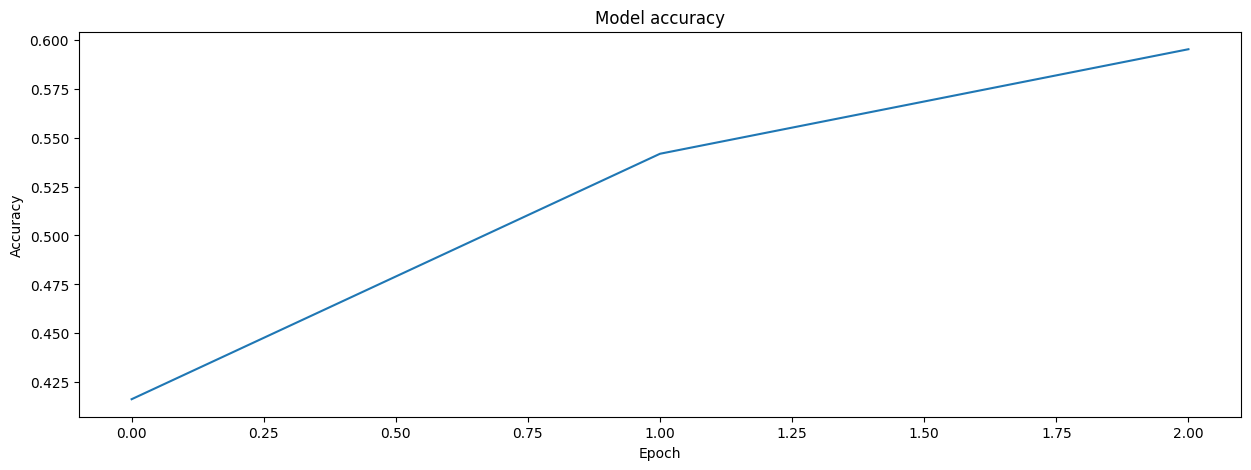

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

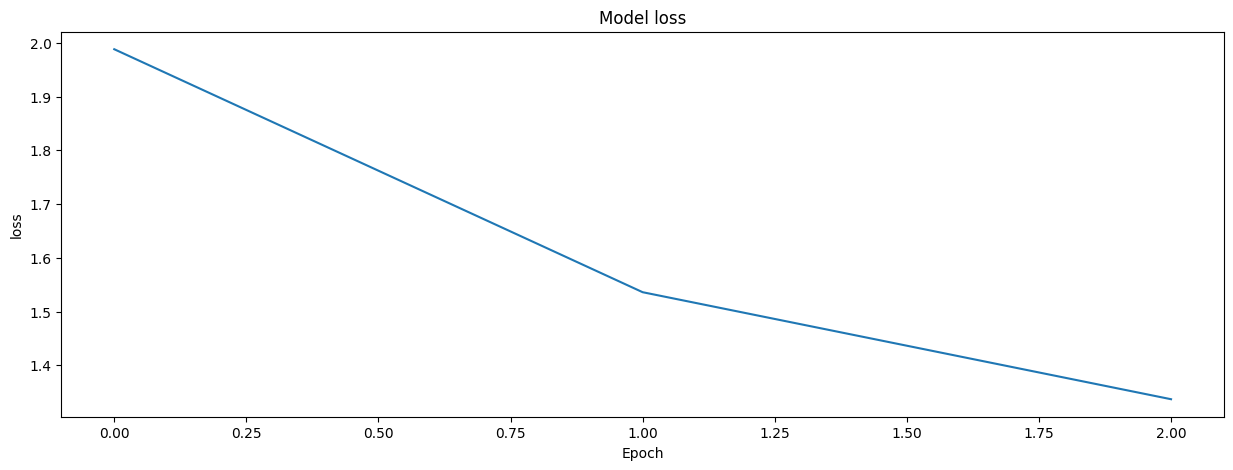

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
test = os.listdir("../happy-whale/input/cropped_test_images/cropped_test_images/")
print(len(test))

27956


In [ ]:
col = ['image']
test_df = pd.DataFrame(test, columns=col)
test_df['predictions'] = ''

In [ ]:
model = load_model(r'../happy-whale/effb7_0_species.h5')

In [ ]:
batch_size=5000
batch_start = 0
batch_end = batch_size
L = len(test_df)

while batch_start < L:
    limit = min(batch_end, L)
    test_df_batch = test_df.iloc[batch_start:limit]
    print(type(test_df_batch))
    X = Loading_Images(test_df_batch, test_df_batch.shape[0], "/cropped_test_images/cropped_test_images")
    X /= 255
    predictions = model.predict(np.array(X), verbose=1)
    for i, pred in enumerate(predictions):
        p=pred.argsort()[-5:][::-1]
        idx=-1
        s=''
        s1=''
        s2=''
        for x in p:
            idx=idx+1
            if pred[x]>0.5:
                s1 = s1 + ' ' +  label_encoder.inverse_transform(p)[idx]
            else:
                s2 = s2 + ' ' + label_encoder.inverse_transform(p)[idx]
        s= s1 + ' new_species' + s2
        s = s.strip(' ')
        test_df.loc[ batch_start + i, 'predictions'] = s
    batch_start += batch_size   
    batch_end += batch_size
    del X
    del test_df_batch
    del predictions
    gc.collect()

<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 6s 28ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 4s 28ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 4s 28ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 4s 28ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 5s 28ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/2956 [00:00<?, ?it/s]

93/93 [==============================] - 3s 31ms/step


In [ ]:
test_df.to_csv('submissionb7_species.csv',index=False)
test_df.head()

,image,predictions
0,e30fb54faba768.jpg,blue_whale new_individual beluga humpback_whal...
1,8e3ccc39902f2c.jpg,new_individual beluga blue_whale humpback_whal...
2,17556ef4f6db01.jpg,blue_whale new_individual humpback_whale belug...
3,3f2ad9c6190045.jpg,new_individual dusky_dolphin short_finned_pilo...
4,9010c7a4259968.jpg,new_individual blue_whale bottlenose_dolphin h...


In [ ]:
test_df.to_csv('submissionb7_species.csv', index = False)